In [53]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from skimage import util

In [ ]:
img_path = 'sar_1.jpg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

In [55]:
rng = np.random.default_rng(42)

def calculate_psnr(original, processed):
    original = original.astype(np.float32)
    processed = processed.astype(np.float32)
    mse = np.mean((original - processed) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))

def add_gaussian_noise(image, mean=0.0, std=50.0):
    noise = rng.normal(mean, std, image.shape)
    noisy = image.astype(np.float32) + noise
    return np.clip(noisy, 0, 255).astype(np.uint8)

img_gn = add_gaussian_noise(img, std=50.0)

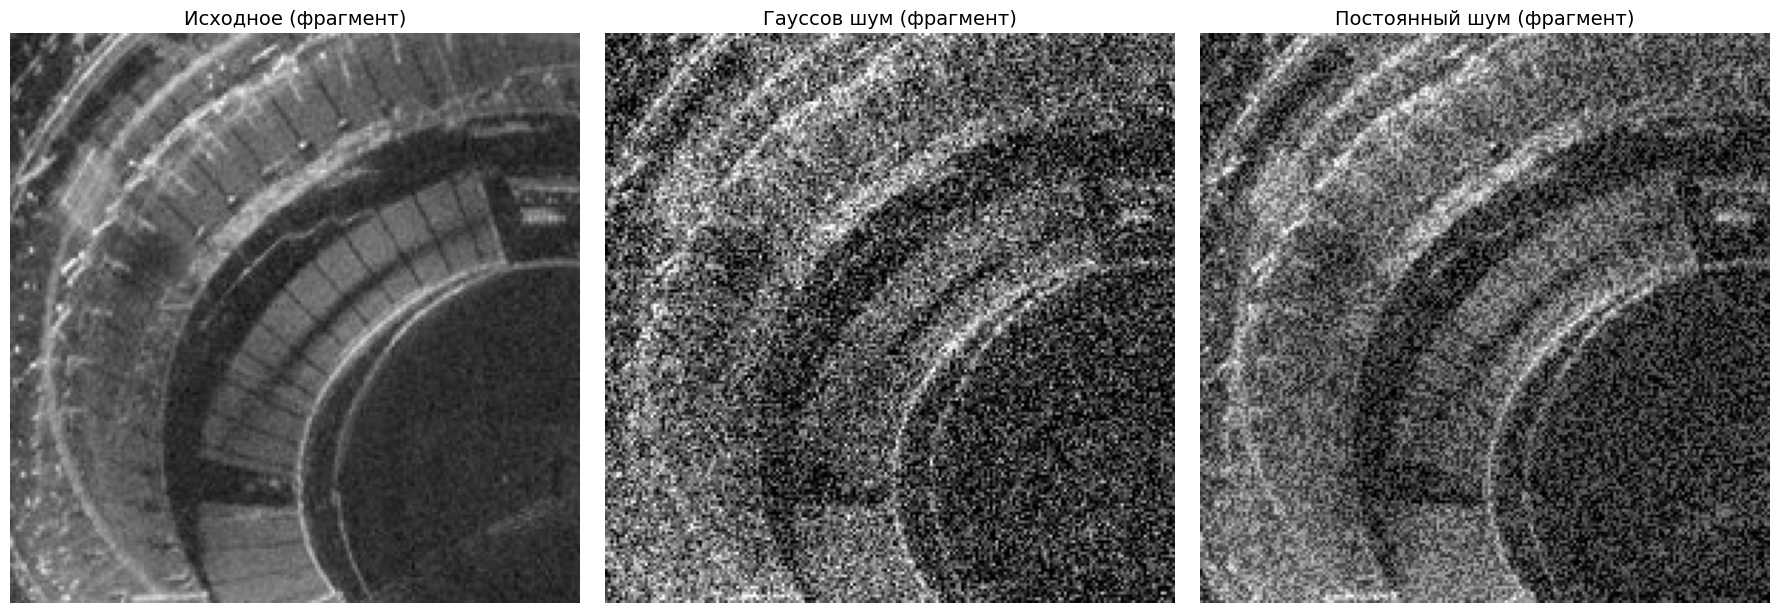

In [56]:
def add_uniform_noise(image, low=-60.0, high=60.0):
    noise = rng.uniform(low, high, image.shape)
    noisy = image.astype(np.float32) + noise
    return np.clip(noisy, 0, 255).astype(np.uint8)

img_un = add_uniform_noise(img, low=-60.0, high=60.0)

h, w = img.shape
crop_y, crop_x = h // 3, w // 3
crop_size = 200

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

crop_orig = img[crop_y:crop_y+crop_size, crop_x:crop_x+crop_size]
crop_gn = img_gn[crop_y:crop_y+crop_size, crop_x:crop_x+crop_size]
crop_un = img_un[crop_y:crop_y+crop_size, crop_x:crop_x+crop_size]

axes[0].imshow(crop_orig, cmap='gray', vmin=0, vmax=255)
axes[0].set_title('Исходное (фрагмент)', fontsize=14)
axes[0].axis('off')

axes[1].imshow(crop_gn, cmap='gray', vmin=0, vmax=255)
axes[1].set_title('Гауссов шум (фрагмент)', fontsize=14)
axes[1].axis('off')

axes[2].imshow(crop_un, cmap='gray', vmin=0, vmax=255)
axes[2].set_title('Постоянный шум (фрагмент)', fontsize=14)
axes[2].axis('off')

plt.tight_layout()
plt.show()



## 2: Тестирование различных фильтров



In [57]:
filter_bank = [
    ('Медианный σ=3', lambda img: cv2.medianBlur(img, 3)),
    ('Медианный σ=5', lambda img: cv2.medianBlur(img, 5)),
    ('Медианный σ=7', lambda img: cv2.medianBlur(img, 7)),
    ('Гауссов σ=1.0', lambda img: cv2.GaussianBlur(img, (3, 3), 1.0)),
    ('Гауссов σ=1.5', lambda img: cv2.GaussianBlur(img, (5, 5), 1.5)),
    ('Гауссов σ=2.0', lambda img: cv2.GaussianBlur(img, (7, 7), 2.0)),
    ('Билатеральный d=5 σ=50', lambda img: cv2.bilateralFilter(img, 5, 50, 50)),
    ('Билатеральный d=9 σ=75', lambda img: cv2.bilateralFilter(img, 9, 75, 75)),
    ('Билатеральный d=9 σ=100', lambda img: cv2.bilateralFilter(img, 9, 100, 100)),
    ('НЛ средние h=10', lambda img: cv2.fastNlMeansDenoising(img, None, 10, 7, 21)),
    ('НЛ средние h=15', lambda img: cv2.fastNlMeansDenoising(img, None, 15, 7, 21)),
    ('НЛ средние h=20', lambda img: cv2.fastNlMeansDenoising(img, None, 20, 7, 31)),
]

def run_filter_bank(original, noisy):
    filtered = {}
    scores = {}
    for label, operation in filter_bank:
        filtered_img = operation(noisy)
        filtered[label] = filtered_img
        scores[label] = calculate_psnr(original, filtered_img)
    return filtered, scores

In [58]:
filters_gn, psnr_gn = run_filter_bank(img, img_gn)
filters_un, psnr_un = run_filter_bank(img, img_un)

baseline_psnr = {
    'Гауссовский шум': calculate_psnr(img, img_gn),
    'Постоянный шум': calculate_psnr(img, img_un),
}

In [59]:
def show_top_results(noise_label, noisy_image, filtered_dict, psnr_dict, top_k=3):
    ordered = sorted(psnr_dict.items(), key=lambda x: x[1], reverse=True)[:top_k]
    
    fig, axes = plt.subplots(1, top_k + 2, figsize=(4 * (top_k + 2), 5))
    
    axes[0].imshow(img, cmap='gray', vmin=0, vmax=255)
    axes[0].set_title('Исходное', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(noisy_image, cmap='gray', vmin=0, vmax=255)
    axes[1].set_title(f'{noise_label}\nPSNR={calculate_psnr(img, noisy_image):.2f}', 
                      fontsize=11, fontweight='bold')
    axes[1].axis('off')
    
    for idx, (label, score) in enumerate(ordered, start=2):
        axes[idx].imshow(filtered_dict[label], cmap='gray', vmin=0, vmax=255)
        axes[idx].set_title(f'{label}\nPSNR={score:.2f}', fontsize=11)
        axes[idx].axis('off')
    
    plt.suptitle(f'Результаты фильтрации: {noise_label}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

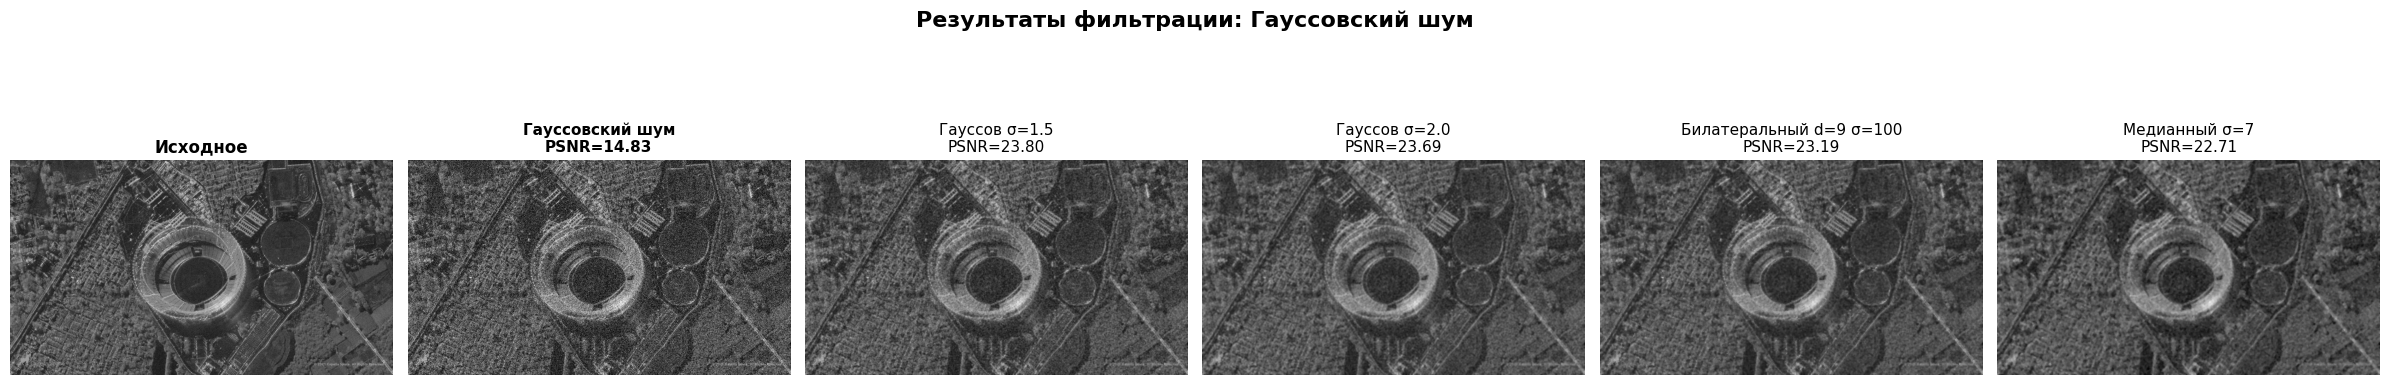

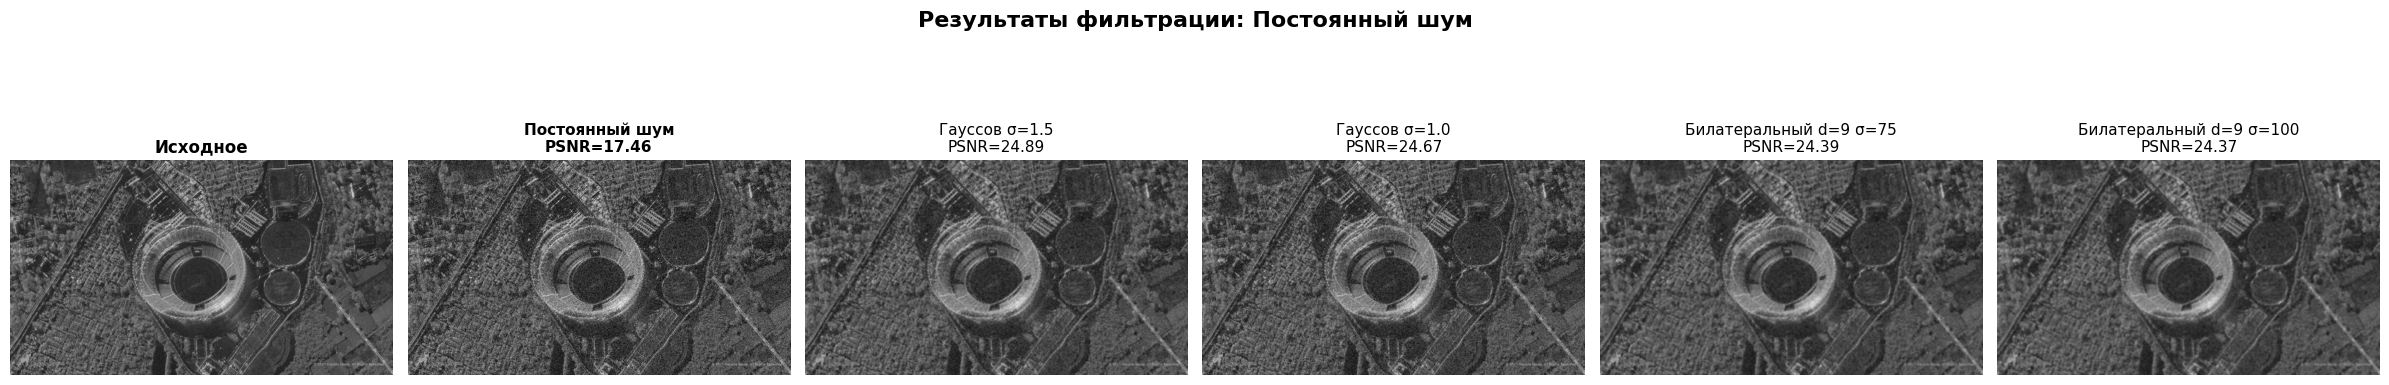

In [60]:
show_top_results('Гауссовский шум', img_gn, filters_gn, psnr_gn, top_k=4)
show_top_results('Постоянный шум', img_un, filters_un, psnr_un, top_k=4)

In [61]:
psnr_results = {
    'Гауссовский шум': psnr_gn,
    'Постоянный шум': psnr_un,
}

psnr_rows = []
for noise_label, metrics in psnr_results.items():
    psnr_rows.append({
        'Тип шума': noise_label,
        'Фильтр': 'Без фильтра',
        'PSNR': baseline_psnr[noise_label],
        'Прирост': 0.0,
    })
    for method, score in metrics.items():
        improvement = score - baseline_psnr[noise_label]
        psnr_rows.append({
            'Тип шума': noise_label,
            'Фильтр': method,
            'PSNR': score,
            'Прирост': improvement,
        })

psnr_table = (
    pd.DataFrame(psnr_rows)
    .sort_values(['Тип шума', 'PSNR'], ascending=[True, False])
    .reset_index(drop=True)
)

for noise_label in psnr_results:
    subset = psnr_table[psnr_table['Тип шума'] == noise_label].copy()
    best = subset.iloc[0]
    worst = subset[subset['Фильтр'] != 'Без фильтра'].iloc[-1]
    baseline = baseline_psnr[noise_label]
    
    

psnr_table


,Тип шума,Фильтр,PSNR,Прирост
0,Гауссовский шум,Гауссов σ=1.5,23.795349,8.970157
1,Гауссовский шум,Гауссов σ=2.0,23.686718,8.861526
2,Гауссовский шум,Билатеральный d=9 σ=100,23.186935,8.361743
3,Гауссовский шум,Медианный σ=7,22.707537,7.882344
4,Гауссовский шум,Гауссов σ=1.0,22.599478,7.774285
5,Гауссовский шум,Медианный σ=5,22.570484,7.745292
6,Гауссовский шум,Билатеральный d=9 σ=75,22.071896,7.246703
7,Гауссовский шум,Медианный σ=3,20.935932,6.110740
8,Гауссовский шум,Билатеральный d=5 σ=50,18.778173,3.952981
9,Гауссовский шум,НЛ средние h=20,14.944361,0.119168


---

## 3: Анализ результатов и выбор лучшего фильтра



In [62]:
best_results = {
    noise_label: max(metrics.items(), key=lambda x: x[1])
    for noise_label, metrics in psnr_results.items()
}

In [63]:
for noise_label, (method, score) in best_results.items():
    baseline = baseline_psnr[noise_label]
    improvement = score - baseline
    print(f'{noise_label}:')
    print(f'  - Лучший фильтр: {method}')
    print(f'  - PSNR: {score:.2f}')
    print(f'  - Исходный PSNR: {baseline:.2f}')


Гауссовский шум:
  - Лучший фильтр: Гауссов σ=1.5
  - PSNR: 23.80
  - Исходный PSNR: 14.83
Постоянный шум:
  - Лучший фильтр: Гауссов σ=1.5
  - PSNR: 24.89
  - Исходный PSNR: 17.46


In [64]:
print('Итоговый вывод\n')

print('1. Результаты по типам шума:\n')
for noise_label in psnr_results:
    method, score = best_results[noise_label]
    baseline = baseline_psnr[noise_label]
    delta = score - baseline
    
    print(f'{noise_label}:')
    print(f'  - Лучший фильтр: {method}')
    print(f'  - PSNR после фильтрации: {score:.2f}')
    print(f'  - PSNR без фильтра: {baseline:.2f}')
    print(f'  - Прирост: {delta:.2f} ({(delta/baseline*100):.1f}%)\n')

print('2. Статистика по типам фильтров:\n')

filter_types = {'Медианный': [], 'Гауссов': [], 'Билатеральный': [], 'НЛ средние': []}
for noise_label, metrics in psnr_results.items():
    for method, score in metrics.items():
        for ftype in filter_types.keys():
            if ftype in method:
                filter_types[ftype].append(score)
                break

for ftype, scores in filter_types.items():
    if scores:
        avg_score = np.mean(scores)
        max_score = np.max(scores)
        min_score = np.min(scores)
        print(f'{ftype}:')
        print(f'  - Средний PSNR: {avg_score:.2f}')
        print(f'  - Диапазон: {min_score:.2f} - {max_score:.2f}\n')

print('3. Выводы:\n')

best_overall = max([(label, method, score) for label, (method, score) in best_results.items()], 
                   key=lambda x: x[2])
print(f'- Лучший общий результат: {best_overall[1]} для {best_overall[0].lower()} (PSNR = {best_overall[2]:.2f})')

avg_improvements = [best_results[label][1] - baseline_psnr[label] for label in psnr_results]
print(f'- Средний прирост PSNR после фильтрации: {np.mean(avg_improvements):.2f}')


Итоговый вывод

1. Результаты по типам шума:

Гауссовский шум:
  - Лучший фильтр: Гауссов σ=1.5
  - PSNR после фильтрации: 23.80
  - PSNR без фильтра: 14.83
  - Прирост: 8.97 (60.5%)

Постоянный шум:
  - Лучший фильтр: Гауссов σ=1.5
  - PSNR после фильтрации: 24.89
  - PSNR без фильтра: 17.46
  - Прирост: 7.43 (42.5%)

2. Статистика по типам фильтров:

Медианный:
  - Средний PSNR: 22.36
  - Диапазон: 20.94 - 23.03

Гауссов:
  - Средний PSNR: 23.99
  - Диапазон: 22.60 - 24.89

Билатеральный:
  - Средний PSNR: 22.59
  - Диапазон: 18.78 - 24.39

НЛ средние:
  - Средний PSNR: 16.65
  - Диапазон: 14.83 - 20.37

3. Выводы:

- Лучший общий результат: Гауссов σ=1.5 для постоянный шум (PSNR = 24.89)
- Средний прирост PSNR после фильтрации: 8.20
